In [4]:
# svm sdca 

def svm_primal(w,y,X,lambd,verbose=False): # computes the primal value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        if verbose:
            print("P({}):y={},dot={},delta_pw={}".format(i,y[i],np.dot(w,X[i,:]),max(0,1-y[i]*np.dot(w,X[i,:]))))
        pw = pw + max(0,1-y[i]*np.dot(w,X[i,:]))
    pw = pw/n 
    pw = pw + 0.5*lambd*np.square(np.linalg.norm(w))
    return pw
def svm_dual(alpha,y,X,lambd,verbose=False): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n): 
        if alpha[i]*y[i] <= 1 and alpha[i]*y[i] >= 0:
            da = da + alpha[i]*y[i]
        else:
            da = da + float("inf")
    da = da / float(n) 
    da = da - 0.5*lambd*np.square(np.linalg.norm(w_alpha(alpha,X,lambd)))
    return da 
def w_alpha(alpha,X,lambd,verbose=False): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + (alpha[i]*X[i,:]/(lambd*n))
    return w

def svm_sdca(y, X, lambd, num_steps, primal_func = svm_primal, dual_func = svm_dual, verbose=False):
  # y_n \in {-1,1} is target,
  # X_{n \time d}: is the row-wise arrange of observations , so each observation has dimension d 
  # Please note that this implementation just includes the output averaging option with paramter T0
  if verbose:
    print("Stochastic coordinate Ascent for SVM")
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(X, axis=1)))
  n, d = X.shape
  # it might be better to change initial value of alpha 
  alpha = np.zeros(n)
  #setting w(alpha_0)
  w = w_alpha(alpha,X,lambd)
  duals = np.zeros(num_steps)# dual function values per iteration
  primals = np.zeros(num_steps) #primal function values per iteration 
  if verbose:
    primal_value = primal_func(w,y,X,lambd)
    dual_value = dual_func(alpha,y,X,lambd)
    print("  Initial primal objective value: {}, Intial dual objective value: {}".format(primal_value, dual_value))
  w_bar = np.zeros(d)
  T_T0 = 0
  alpha_bar = np.zeros(n)
  for cur_step in range(num_steps):
    # pick a random dual coordinate
    rperm = np.random.permutation(n)
    for ii in rperm: 
        alpha_i_old = alpha[ii]
        xi = X[ii,:]
        yi = y[ii]
        inv_sqi = inv_sq_row_norms[ii]
        # coordinate update step 
        delta_alpha_i = yi*max(0,min(1,(lambd*n*(1-yi*np.dot(xi,w))*inv_sqi)+alpha_i_old*yi)) - alpha_i_old
        # update the dual and primal paramters
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi/(lambd*n)
    
    # output averaging 
#     if cur_step > T0:
#        w_bar = w_bar + w
#        alpha_bar = alpha_bar + alpha
#        T_T0 = T_T0 +1 
    
    duals[cur_step] = dual_func(alpha,y,X,lambd)
    primals[cur_step] = primal_func(w,y,X,lambd)
    if verbose: #and cur_step % n == 0 and cur_step > 0
      print("step:{},primal: {},dual: {}\n".format(cur_step,primals[cur_step], duals[cur_step] ))
  return (w, alpha ,primals,duals)

In [5]:
def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)

%pylab
%matplotlib inline

from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [15]:
n = 32561; 
d = 123; 

#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
# X = preprocessing.normalize(X, norm='l2')
lambd = 100.0/float(n)
passes = 100

In [34]:
from sklearn import svm
classi = svm.LinearSVC(C = 1.0/(n*lambd), loss = 'hinge', fit_intercept=False,tol = 0.000000001, max_iter = 1000000000)
classi = classi.fit(X,y)
w = classi.coef_
opt_primal = svm_primal(w,y,X,lambd)
def primal_sub(w,y,X,lambd):
   return svm_primal(w,y,X,lambd) - opt_primal
def dual_sub(alpha,y,X,lambd): 
   return opt_primal - svm_dual(alpha,y,X,lambd) 



In [35]:
epochs = 400
w, alpha ,primals,duals = svm_sdca(y, X, lambd, epochs, primal_func = primal_sub, dual_func = dual_sub, verbose=False)

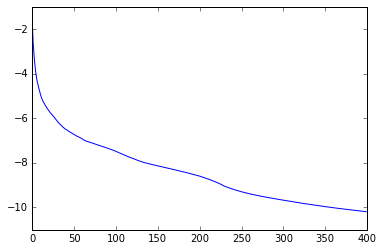

In [36]:
plt.plot(range(epochs) ,np.log10(duals))

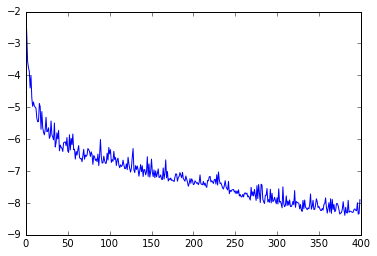

In [37]:
plt.plot(range(epochs) ,np.log10(primals))

In [35]:
opt_primal

array([ 0.35115587])